Random Forest Performance:
              precision    recall  f1-score   support

           0       0.66      0.39      0.49       117
           1       0.45      0.71      0.55        83

    accuracy                           0.53       200
   macro avg       0.56      0.55      0.52       200
weighted avg       0.57      0.53      0.52       200

SVM Performance:
              precision    recall  f1-score   support

           0       0.75      0.38      0.50       117
           1       0.48      0.82      0.61        83

    accuracy                           0.56       200
   macro avg       0.61      0.60      0.55       200
weighted avg       0.64      0.56      0.54       200



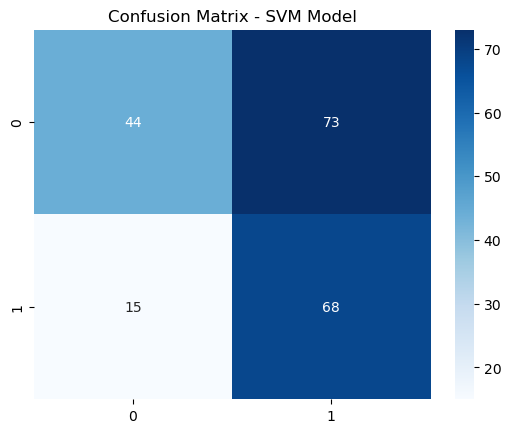

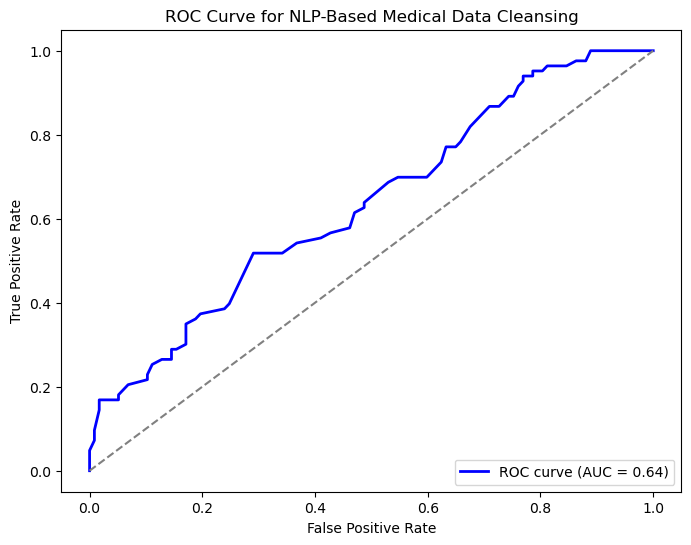

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Load Spacy model for NLP
nlp = spacy.load("en_core_web_sm")

# Load dataset
df = pd.read_csv("medical_records.csv")
df.columns = df.columns.str.strip()  
df.to_csv("Duplicate_Removed.csv", index=False)

# Fill missing text data
df = pd.read_csv("Duplicate_Removed.csv")
df["Notes"] = df["Notes"].fillna("No medical history available")
df.to_csv("Filled_missing.csv", index=False)

# Text Normalization (Lowercase & Remove special characters)
df = pd.read_csv("Filled_missing.csv")
df["Cleaned_Notes"] = df["Notes"].str.lower().str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
df.to_csv("cleaned_medical_data.csv", index=False)

df = pd.read_csv("cleaned_medical_data.csv")
# Lemmatization using Spacy
df["Cleaned_Notes"] = df["Cleaned_Notes"].apply(lambda text: " ".join([token.lemma_ for token in nlp(text)]))
df.to_csv("lemmatized.csv", index=False)

df = pd.read_csv("lemmatized.csv")
# Data De-identification (Anonymization)
df["Anonymized_Notes"] = df["Cleaned_Notes"].astype(str).apply(
    lambda text: re.sub(r'\b(?:John|Mary|Dr\.|Hospital|Phone)\b', 'REDACTED', text, flags=re.IGNORECASE)
)
df.to_csv("Anonymization.csv", index=False)

# Context-Based Error Correction (Flag incorrect entries)
df["is_incorrect"] = df["Life Threats"].astype(str).apply(lambda text: 1 if "yes" in text.lower() else 0)
df.to_csv("Error Correcrtion.csv", index=False)

# Convert text data into numerical representation
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["Anonymized_Notes"]).toarray()
y = df["is_incorrect"]

# Step 3: Handle Class Imbalance with SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Advanced Model: SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Step 5: Evaluate Models
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

print("SVM Performance:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SVM Model")
plt.show()

# Generate predictions and compute ROC curve
if len(np.unique(y_train)) == 1:
    print("Warning: Training data contains only one class. ROC curve cannot be computed.")
else:
    fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, -1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for NLP-Based Medical Data Cleansing')
    plt.legend(loc='lower right')
    plt.show()
